## Sentiment Analysis (with NLP) for Taylor Swift Billboard Top 100 Songs

In [7]:
import numpy as np
import pandas as pd
import re
import string
from tqdm.notebook import tqdm
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex

import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
# %pip install pyvis

from urllib.request import urlopen
from bs4 import BeautifulSoup
from time import sleep

plt.rc('figure',figsize=(17,13))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/arianaschindler/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.9/748.9 kB 11.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.6 MB/s eta 0:00:00
  Created wheel for pyvis: filename=pyvis-0.3.1-py3-none-any.whl size=755835 sha256=af67c598b3eff0da7fbc188547a6b3a559c0fe8b8acb1e412731d5a84e6a2757
  Stored in directory: /Users/arianaschindler/Library/Caches/pip/wheels/37/f9/93/44dd6cbfb2ead35307b114d27af8c6a14d5762a462af1e04f5
Successfully built pyvis
Note: you may need to restart the kernel to use updated packages.


#### Possible insights to be gained:
* Which sentiment resonates with fans
* Make suggestions for future songwriting sentiments based on historical data
* Connect artists and songwriters based on data
* Opportunity to expand this beyond a single artist to analyze multiple fan-bases at once
* Can restrict data to analyze independent years

## Reading in Data and Quick Cleaning

In [90]:
#reading in billboard top 100 data
df = pd.read_csv('../personal_github/data/charts.csv')
df.date = pd.to_datetime(df.date)
df.head()

date  rank           song                         artist  last-week  \
0 2021-11-06     1     Easy On Me                          Adele        1.0   
1 2021-11-06     2           Stay  The Kid LAROI & Justin Bieber        2.0   
2 2021-11-06     3  Industry Baby        Lil Nas X & Jack Harlow        3.0   
3 2021-11-06     4     Fancy Like                   Walker Hayes        4.0   
4 2021-11-06     5     Bad Habits                     Ed Sheeran        5.0   

   peak-rank  weeks-on-board  
0          1               3  
1          1              16  
2          1              14  
3          3              19  
4          2              18

In [91]:
#cutting the df down to only taylor swift as the artist
tay = df[df['artist']=='Taylor Swift']
tay.shape

(1023, 7)

In [92]:
#checking the first few rows of the taylor df
tay.head()

date  rank                                               song  \
536  2021-10-02    37                  Wildest Dreams (Taylor's Version)   
2660 2021-05-08    61                                             Willow   
2759 2021-05-01    60                                             Willow   
2789 2021-05-01    90  Mr. Perfectly Fine (Taylor's Version) (From Th...   
2829 2021-04-24    30  Mr. Perfectly Fine (Taylor's Version) (From Th...   

            artist  last-week  peak-rank  weeks-on-board  
536   Taylor Swift        NaN         37               1  
2660  Taylor Swift       60.0          1              20  
2759  Taylor Swift       62.0          1              19  
2789  Taylor Swift       30.0         30               3  
2829  Taylor Swift       90.0         30               2

For each unique song, I want to keep only the most recent record.

In [93]:
#condensing the df down to only hold the most recent row of each unique song
condense = tay.sort_values('weeks-on-board', ascending=False).drop_duplicates(['song'])

In [238]:
#checking the first few rows of the df
condense.head()

date  rank                     song        artist  last-week  \
60349 2010-04-17    50       You Belong With Me  Taylor Swift       45.0   
32549 2015-08-15    50             Shake It Off  Taylor Swift       47.0   
63648 2009-08-29    49               Love Story  Taylor Swift       46.0   
70348 2008-05-17    49   Teardrops On My Guitar  Taylor Swift       48.0   
43548 2013-07-06    49  I Knew You Were Trouble  Taylor Swift       49.0   

       peak-rank  weeks-on-board  
60349          2              50  
32549          1              50  
63648          4              49  
70348         13              48  
43548          2              36

In [144]:
#removing this song after visual inspection showed this was included but is not by taylor
condense = condense[condense['song'] != 'Breathless']

In [236]:
#renaming because the df had a period at the end of the name
condense['song'][43548] = 'I Knew You Were Trouble'

In [145]:
#finding the longest song title to use later in restricting our list of scraped songs
length = 0
for i in condense['song']:
    if len(i) > length:
        length = len(i)
print(length)

54


## Scraping lyrics for each of Taylor's songs which has appeared in the Billboard Top 100

In [154]:
#identifying a list of songs i want the scraper to find lyrics for
song_list = list(condense['song'])
len(song_list)

119

In [258]:
#checking the song list
song_list

['You Belong With Me',
 'Shake It Off',
 'Love Story',
 'Teardrops On My Guitar',
 'I Knew You Were Trouble.',
 'Our Song',
 'Blank Space',
 'Delicate',
 'Style',
 'Wildest Dreams',
 'We Are Never Ever Getting Back Together',
 'Mine',
 'Red',
 'Lover',
 'White Horse',
 'You Need To Calm Down',
 'Fifteen',
 'Begin Again',
 'Willow',
 '22',
 '...Ready For It?',
 'Ours',
 'Sparks Fly',
 'Look What You Made Me Do',
 'Back To December',
 'Mean',
 'Tim McGraw',
 "Should've Said No",
 'Picture To Burn',
 'Today Was A Fairytale',
 'Fearless',
 'Cardigan',
 'Eyes Open',
 'The Story Of Us',
 'Out Of The Woods',
 'The Man',
 'Crazier',
 'New Romantics',
 'The 1',
 "You're Not Sorry",
 'Gorgeous',
 'The Archer',
 'Forever & Always',
 "Mr. Perfectly Fine (Taylor's Version) (From The Vault)",
 'Jump Then Fall',
 'Change',
 'Speak Now',
 'Invisible String',
 "Love Story (Taylor's Version)",
 'Mirrorball',
 'Welcome To New York',
 'The Last Great American Dynasty',
 'My Tears Ricochet',
 'Betty',
 'Au

In [260]:
#artist for which the lyrics need to be written
artist = "taylorswift"
processed_songs = []

#preprocessing the song names for scraping
for song in song_list:
    numbers_in_brackets_removed = re.sub(r'\(.\)',"",song)
    processed_song = re.sub(r'\W+', '', numbers_in_brackets_removed).lower()
    processed_songs.append(processed_song)
    
print(len(processed_songs))

#removing duplicate songs
processed_songs = list(set(processed_songs))
print(len(processed_songs))
print(processed_songs)

119
119
['beginagain', 'madwoman', 'sparksfly', 'untouchable', 'happiness', 'wildestdreams', 'lovestory', 'ronan', 'dearjohn', 'gorgeous', 'lookwhatyoumademedo', 'cardigan', 'betty', 'mytearsricochet', 'shakeitoff', 'the1', 'wonderland', 'shouldvesaidno', 'sweeterthanfiction', 'champagneproblems', 'outofthewoods', 'wildestdreamstaylorsversion', 'superman', 'lover', '22', 'enchanted', 'cruelsummer', 'goldrush', 'youneedtocalmdown', 'paperrings', 'thisismetrying', 'yourenotsorry', 'christmastreefarm', 'cowboylikeme', 'teardropsonmyguitar', 'closure', 'tisthedamnseason', 'weareneverevergettingbacktogether', 'londonboy', 'blankspace', 'youbelongwithmetaylorsversion', 'timmcgraw', 'nevergrowup', 'crazier', 'youareinlove', 'mrperfectlyfinetaylorsversionfromthevault', 'ithinkheknows', 'deathbyathousandcuts', 'thestoryofus', 'thewayilovedyoutaylorsversion', 'mine', 'thewayilovedyou', 'peace', 'willow', 'readyforit', 'todaywasafairytale', 'oursong', 'iforgotthatyouexisted', 'mean', 'lovestoryta

In [261]:
#url to scrape the lyrics from
base_url = "https://www.azlyrics.com/lyrics/{}/{}.html"

#file in which the lyrics would be saved
lyrics_file = "../personal_github/data/scraped_lyrics.txt"
name_list = []

lyrics_not_found_for = []

#delay after each execution of call for not exceeding the requests count and also not to overburden the server
delay = 10

with open(lyrics_file, "w") as file:
    
    for song in processed_songs:
        final_url = base_url.format(artist,song)

        try:
            html_page = urlopen(final_url)
            soup = BeautifulSoup(html_page, 'html.parser')

            html_pointer = soup.find('div', attrs={'class':'ringtone'})
            song_name = html_pointer.find_next('b').contents[0].strip()
            lyrics = html_pointer.find_next('div').text.strip()
            name_list.append(song_name)

            file.write("###")
            file.write("\n\n")
            file.write(lyrics)
            file.write("\n\n")
            
            print("Lyrics successfully written to file for : " + song_name)
            
        except:
            print("Lyrics not found for : " + song)
            lyrics_not_found_for.append(song)
            
        finally:
            sleep(delay)

Lyrics successfully written to file for : "Begin Again"
Lyrics successfully written to file for : "mad woman"
Lyrics successfully written to file for : "Sparks Fly"
Lyrics successfully written to file for : "Untouchable"
Lyrics successfully written to file for : "happiness"
Lyrics successfully written to file for : "Wildest Dreams"
Lyrics successfully written to file for : "Love Story"
Lyrics successfully written to file for : "Ronan"
Lyrics successfully written to file for : "Dear John"
Lyrics successfully written to file for : "Gorgeous"
Lyrics successfully written to file for : "Look What You Made Me Do"
Lyrics successfully written to file for : "cardigan"
Lyrics successfully written to file for : "betty"
Lyrics successfully written to file for : "my tears ricochet"
Lyrics successfully written to file for : "Shake It Off"
Lyrics successfully written to file for : "the 1"
Lyrics successfully written to file for : "Wonderland"
Lyrics successfully written to file for : "Should've Said 

In [262]:
print("Total count : ", len(song_list),"songs")
print("Lyrics successfully scraped for : ", len(song_list)-len(lyrics_not_found_for), "songs")
print("Lyrics not found for :", len(lyrics_not_found_for),"songs\n")
print("\nHere's the list :\n")
print(lyrics_not_found_for)

Total count :  119 songs
Lyrics successfully scraped for :  119 songs
Lyrics not found for : 0 songs


Here's the list :

[]


In [278]:
#cleaning the song names list produced by the scraper
name_list = [item.replace('"', '') for item in name_list]

In [293]:
#cleaning song names further
def convert_into_uppercase(a):
    return a.group(1) + a.group(2).upper()

names = []
for s in name_list:
    names.append(re.sub("(^|\s)(\S)", convert_into_uppercase, s))

In [270]:
#opening the text file where we saved the scraped lyrics
lyrics = open('../personal_github/data/scraped_lyrics.txt', 'r')
lyrics = lyrics.read()
lyrics_list = lyrics.replace('\n', ' ').split("###")
lyrics_list = lyrics_list
print(lyrics_list)

['', "  Took a deep breath in the mirror He didn't like it when I wore high heels But I do Turn the lock and put my headphones on He always said he didn't get this song But I do, I do  Walked in expecting you'd be late But you got here early and you stand and wave I walk to you You pull my chair out and help me in And you don't know how nice that is But I do  And you throw your head back laughing like a little kid I think it's strange that you think I'm funny 'cause he never did I've been spending the last eight months Thinking all love ever does is break and burn and end But on a Wednesday in a cafe I watched it begin again  You said you never met one girl Who had as many James Taylor records as you But I do We tell stories and you don't know why I'm coming off a little shy But I do  But you throw your head back laughing like a little kid I think it's strange that you think I'm funny 'cause he never did  I've been spending the last eight months Thinking all love ever does is break and

In [271]:
#restricting our list of scraped songs to make sure it downt include blank spaces or song titles
for i in lyrics_list:
    if len(i) < 54:
        lyrics_list.remove(i)
print(len(lyrics_list))

119


In [272]:
#checking a song
lyrics_list[24]

"  It feels like a perfect night to dress up like hipsters And make fun of our exes, uh uh, uh uh It feels like a perfect night for breakfast at midnight To fall in love with strangers, uh uh, uh uh  Yeah We're happy, free, confused, and lonely at the same time It's miserable and magical Oh, yeah Tonight's the night when we forget about the deadlines It's time  Uh oh! I don't know about you But I'm feeling 22 Everything will be alright If you keep me next to you You don't know about me But I'll bet you want to Everything will be alright If we just keep dancing like we're 22, ooh-ooh 22, ooh-ooh  It seems like one of those nights This place is too crowded Too many cool kids, uh uh, uh uh (who's Taylor Swift anyway, ew?) It seems like one of those nights We ditch the whole scene and end up dreaming Instead of sleeping  Yeah We're happy, free, confused, and lonely in the best way It's miserable and magical Oh, yeah Tonight's the night when we forget about the heartbreaks It's time  Uh oh!

In [315]:
#renaming a song that didn't get capitalized
names[36] = "'Tis The Damn Season"

In [316]:
#creating a df of the scraped songs and their lyrics
tay_df = pd.DataFrame()
tay_df['song'] = names
tay_df['lyrics'] = lyrics_list

In [317]:
#merging the scraped data with the condensed df and checking the first few rows of the output
merge = pd.merge(condense, tay_df, on='song', how='left')
merge.head(20)

date  rank                                     song        artist  \
0  2010-04-17    50                       You Belong With Me  Taylor Swift   
1  2015-08-15    50                             Shake It Off  Taylor Swift   
2  2009-08-29    49                               Love Story  Taylor Swift   
3  2008-05-17    49                   Teardrops On My Guitar  Taylor Swift   
4  2013-07-06    49                  I Knew You Were Trouble  Taylor Swift   
5  2008-06-14    48                                 Our Song  Taylor Swift   
6  2015-07-18    50                              Blank Space  Taylor Swift   
7  2018-11-17    49                                 Delicate  Taylor Swift   
8  2015-08-01    48                                    Style  Taylor Swift   
9  2016-03-12    46                           Wildest Dreams  Taylor Swift   
10 2013-02-02    46  We Are Never Ever Getting Back Together  Taylor Swift   
11 2011-01-22    50                                     Mine  Taylor Swift   
12 2013-12-14    51                                      Red  Taylor Swift   
13 2020-01-25    50                                    Lover  Taylor Swift   
14 2009-04-25    44                              White Horse  Taylor Swift   
15 2019-11-16    46                    You Need To Calm Down  Taylor Swift   
16 2010-02-06    40                                  Fifteen  Taylor Swift   
17 2013-03-02    65                              Begin Again  Taylor Swift   
18 2021-05-08    61                                   Willow  Taylor Swift   
19 2013-07-27    65                                       22  Taylor Swift   

    last-week  peak-rank  weeks-on-board  \
0        45.0          2              50   
1        47.0          1              50   
2        46.0          4              49   
3        48.0         13              48   
4        49.0          2              36   
5        48.0         16              36   
6        45.0          1              36   
7        43.0         12              35   
8        48.0          6              32   
9        46.0          5              27   
10       39.0          1              24   
11       31.0          3              23   
12       53.0          6              22   
13       36.0         10              22   
14       39.0         13              22   
15       52.0          2              21   
16       36.0         23              21   
17       71.0          7              20   
18       60.0          1              20   
19       55.0         20              20   

                                               lyrics  
0     You're on the phone with your girlfriend She...  
1     I stay out too late Got nothing in my brain ...  
2     We were both young when I first saw you I cl...  
3     Drew looks at me I fake a smile so he won't ...  
4     Once upon a time, a few mistakes ago I was i...  
5     I was riding shotgun With my hair undone In ...  
6     Nice to meet you, where you been? I could sh...  
7     This ain't for the best My reputation's neve...  
8     Midnight You come and pick me up, no headlig...  
9     He said, "Let's get out of this town Drive o...  
10    I remember when we broke up the first time S...  
11    You were in college working part-time waitin...  
12    Loving him is like driving a new Maserati do...  
13    We could leave the Christmas lights up 'til ...  
14    Say you're sorry That face of an angel Comes...  
15    You are somebody that I don't know But you'r...  
16    You take a deep breath and you walk through ...  
17    Took a deep breath in the mirror He didn't l...  
18    I'm like the water when your ship rolled in ...  
19    It feels like a perfect night to dress up li...

In [324]:
#extracting the year from the date
merge = merge.assign(year = merge.date.dt.year)

In [365]:
#further restricting to our final df features
tay_df = merge[['year', 'song', 'weeks-on-board', 'lyrics', 'peak-rank']]
tay_df

year                     song  weeks-on-board  \
0    2010       You Belong With Me              50   
1    2015             Shake It Off              50   
2    2009               Love Story              49   
3    2008   Teardrops On My Guitar              48   
4    2013  I Knew You Were Trouble              36   
..    ...                      ...             ...   
114  2012             All Too Well               1   
115  2012           Stay Stay Stay               1   
116  2012           State Of Grace               1   
117  2011                 Superman               1   
118  2010                 Innocent               1   

                                                lyrics  peak-rank  
0      You're on the phone with your girlfriend She...          2  
1      I stay out too late Got nothing in my brain ...          1  
2      We were both young when I first saw you I cl...          4  
3      Drew looks at me I fake a smile so he won't ...         13  
4      Once upon a time, a few mistakes ago I was i...          2  
..                                                 ...        ...  
114    I walked through the door with you, the air ...         80  
115    I'm pretty sure we almost broke up last nigh...         91  
116    I'm walking fast through the traffic lights ...         13  
117    Tall, dark and superman He puts papers in hi...         26  
118    I guess you really did it this time Left you...         27  

[119 rows x 5 columns]

In [366]:
#normalizing
tay_df['lyrics'] = tay_df['lyrics'].str.lower()

#punctuations
tay_df['lyrics'] = tay_df['lyrics'].str.replace('[^\w\s]', '')

#numbers
tay_df['lyrics'] = tay_df['lyrics'].str.replace('\d', '')

/var/folders/3g/vw1_gtr158n9qdfw2zlr2jx40000gn/T/ipykernel_40065/4140875332.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/3g/vw1_gtr158n9qdfw2zlr2jx40000gn/T/ipykernel_40065/4140875332.py:8: FutureWarning:

The default value of regex will change from True to False in a future version.



In [333]:
#removing stopwords
# nltk.download('stopwords')
from nltk.corpus import stopwords

In [367]:
#stopwords
sw = stopwords.words('english')
tay_df['lyrics'] = tay_df['lyrics'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [368]:
#rarewwords
drops = pd.Series(' '.join(tay_df['lyrics']).split()).value_counts()[-1000:]
tay_df['lyrics'] = tay_df['lyrics'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [341]:
# pip install textblob
from textblob import Word, TextBlob
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [369]:
#lemmatization
tay_df['lyrics'] = tay_df['lyrics'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
tay_df['lyrics'].head(10)

0    youre phone girlfriend shes upset shes going s...
1    stay late got nothing thats people say mmmmmm ...
2    young first saw close eye flashback start im s...
3    drew look fake smile wont see want im everythi...
4    upon time mistake ago got alone found found fo...
5    riding shotgun hair undone front seat car he g...
6    nice meet could show incredible thing magic ma...
7    aint best reputation never worse must like can...
8    midnight come pick headlight long drive could ...
9    said let get town drive city away crowd though...
Name: lyrics, dtype: object

## Text Visualization

In [370]:
#value counts for words in lyrics
val = tay_df['lyrics'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

val.columns = ["words", "val"]
val.head()

words    val
0  belong   25.0
1      im  354.0
2    know  320.0
3     see  173.0
4    cant  113.0

In [371]:
#checking the shape of the mini words df
val.shape

(1657, 2)

In [372]:
#checking how many of those words are unique
val["words"].nunique()

1657

In [373]:
#quick statistics on the words df
val['val'].describe()

count    1657.000000
mean       12.563669
std        27.986858
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max       358.000000
Name: val, dtype: float64

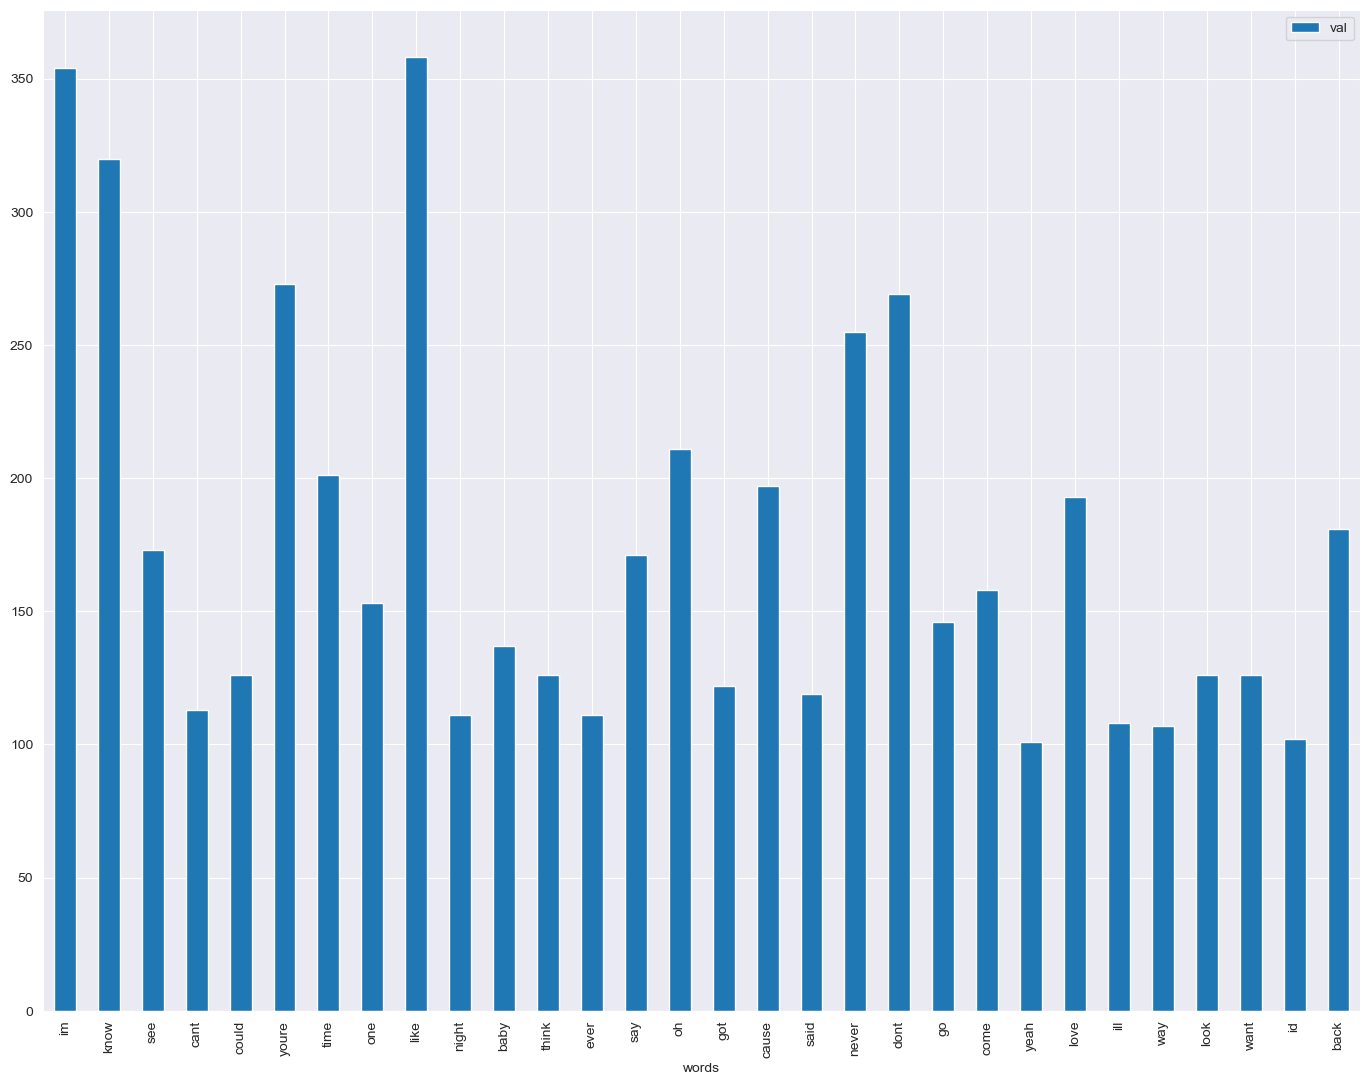

In [374]:
#quick visualization of words which occur more than 100 times
import matplotlib.pyplot as plt
val[val['val'] > 100].plot.bar(x='words', y='val')
plt.show()

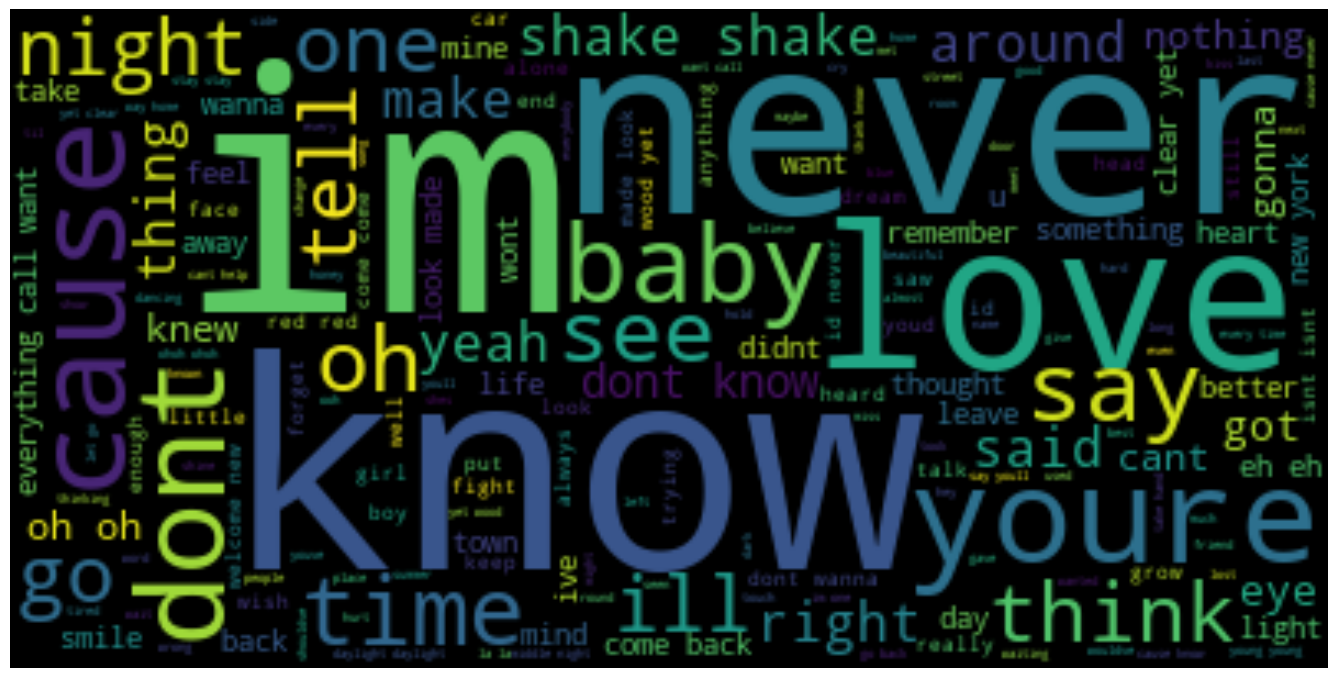

In [375]:
#word cloud
text = " ".join(i for i in tay_df.lyrics)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

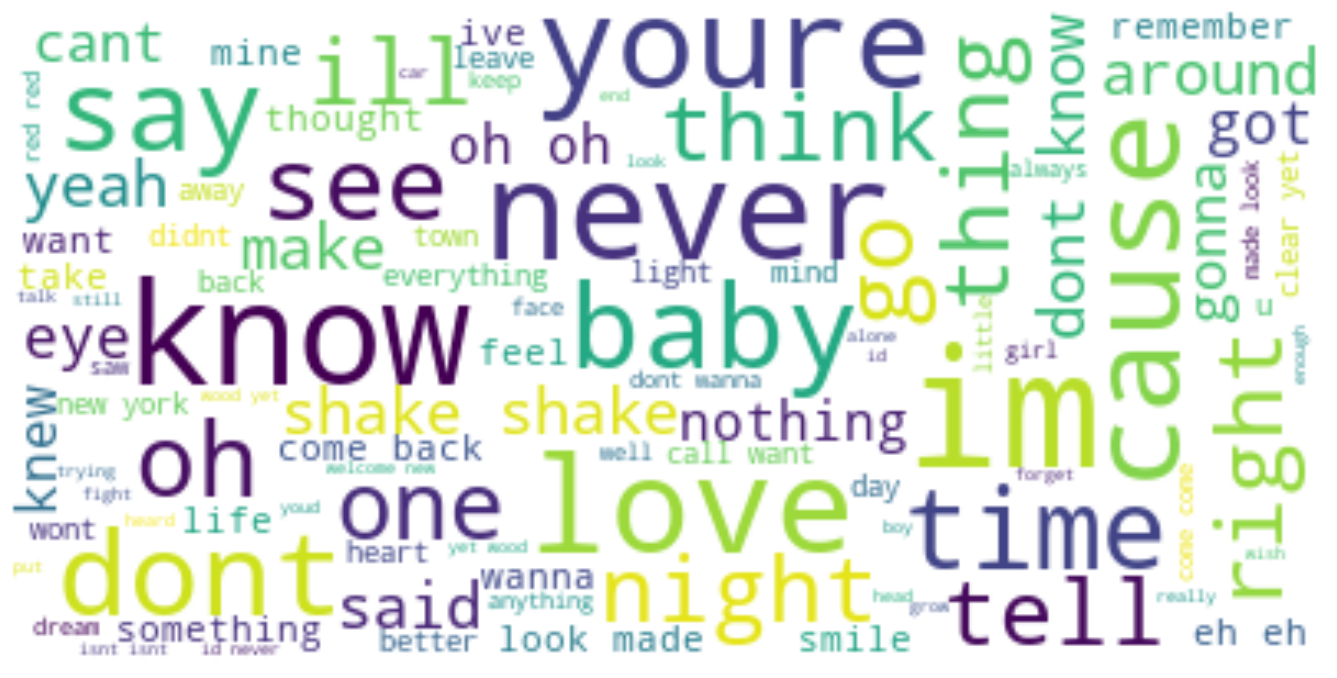

In [376]:
#expanding the word cloud
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Sentiment Analysis

In [377]:
#checking the first few rows of the df
tay_df.head()

year                     song  weeks-on-board  \
0  2010       You Belong With Me              50   
1  2015             Shake It Off              50   
2  2009               Love Story              49   
3  2008   Teardrops On My Guitar              48   
4  2013  I Knew You Were Trouble              36   

                                              lyrics  peak-rank  
0  youre phone girlfriend shes upset shes going s...          2  
1  stay late got nothing thats people say mmmmmm ...          1  
2  young first saw close eye flashback start im s...          4  
3  drew look fake smile wont see want im everythi...         13  
4  upon time mistake ago got alone found found fo...          2

In [360]:
# nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [378]:
#calculating and assigning polarity score to each song
tay_df['polarity_score'] = tay_df['lyrics'].apply(lambda x: sia.polarity_scores(x)['compound'])
tay_df.head()

year                     song  weeks-on-board  \
0  2010       You Belong With Me              50   
1  2015             Shake It Off              50   
2  2009               Love Story              49   
3  2008   Teardrops On My Guitar              48   
4  2013  I Knew You Were Trouble              36   

                                              lyrics  peak-rank  \
0  youre phone girlfriend shes upset shes going s...          2   
1  stay late got nothing thats people say mmmmmm ...          1   
2  young first saw close eye flashback start im s...          4   
3  drew look fake smile wont see want im everythi...         13   
4  upon time mistake ago got alone found found fo...          2   

   polarity_score  
0          0.8855  
1         -0.9996  
2          0.9697  
3          0.9763  
4         -0.9988

## Sentiment Modeling

In [379]:
#adding a classification label to the df for each song
tay_df["sentiment_label"] = tay_df['lyrics'].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
tay_df.head(20)

year                                     song  weeks-on-board  \
0   2010                       You Belong With Me              50   
1   2015                             Shake It Off              50   
2   2009                               Love Story              49   
3   2008                   Teardrops On My Guitar              48   
4   2013                  I Knew You Were Trouble              36   
5   2008                                 Our Song              36   
6   2015                              Blank Space              36   
7   2018                                 Delicate              35   
8   2015                                    Style              32   
9   2016                           Wildest Dreams              27   
10  2013  We Are Never Ever Getting Back Together              24   
11  2011                                     Mine              23   
12  2013                                      Red              22   
13  2020                                    Lover              22   
14  2009                              White Horse              22   
15  2019                    You Need To Calm Down              21   
16  2010                                  Fifteen              21   
17  2013                              Begin Again              20   
18  2021                                   Willow              20   
19  2013                                       22              20   

                                               lyrics  peak-rank  \
0   youre phone girlfriend shes upset shes going s...          2   
1   stay late got nothing thats people say mmmmmm ...          1   
2   young first saw close eye flashback start im s...          4   
3   drew look fake smile wont see want im everythi...         13   
4   upon time mistake ago got alone found found fo...          2   
5   riding shotgun hair undone front seat car he g...         16   
6   nice meet could show incredible thing magic ma...          1   
7   aint best reputation never worse must like can...         12   
8   midnight come pick headlight long drive could ...          6   
9   said let get town drive city away crowd though...          5   
10  remember broke first time saying ive enough ca...          1   
11  college working parttime waiting table left sm...          3   
12  loving like driving new maserati deadend stree...          6   
13  could leave christmas light til place make rul...         10   
14  say youre sorry face angel come need back fort...         13   
15  somebody dont know youre taking shot like im l...          2   
16  take deep breath walk door morning first day s...         23   
17  took deep breath mirror didnt like wore high h...          7   
18  im like water night rough cut like knife opens...          1   
19  feel like perfect night dress like make fun ex...         20   

    polarity_score sentiment_label  
0           0.8855             pos  
1          -0.9996             neg  
2           0.9697             pos  
3           0.9763             pos  
4          -0.9988             neg  
5           0.9326             pos  
6           0.1916             pos  
7           0.8808             pos  
8           0.9817             pos  
9           0.9912             pos  
10          0.9915             pos  
11          0.9857             pos  
12          0.9954             pos  
13          0.9936             pos  
14          0.8807             pos  
15          0.9845             pos  
16          0.9917             pos  
17          0.9667             pos  
18          0.9300             pos  
19          0.9976             pos

In [380]:
#checking the distribution of positive and negative sentiments
tay_df["sentiment_label"].value_counts()

pos    92
neg    27
Name: sentiment_label, dtype: int64

In [382]:
#checking the average number of weeks spent on the board for each sentiment
tay_df.groupby("sentiment_label")["weeks-on-board"].mean()

sentiment_label
neg    7.185185
pos    9.021739
Name: weeks-on-board, dtype: float64